In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import utils.random_functions as rf
import utils.options as op
import utils.optimization as ot

In [2]:
# Placeholder values (replace with your actual data calculations)
num_assets = 2 # Simulating only two variables for this function
initial_prices = np.array([100, 80]) # Placeholder initial prices
mu = np.array([-0.08, 0.05]) # Annualized expected returns
cov_matrix = np.array([
    [0.1, 0.02],
    [0.02, 0.08]
]) # Annualized covariance matrix

n_days = 365  # Number of trading days in a year
num_simulations = 1000 # Number of simulations

# Convert annualized parameters to daily parameters
daily_mu = mu / n_days
daily_cov = cov_matrix / n_days

# Number of steps for the random walk
num_steps = n_days # Using the projection_days from the preceding code

# Generate the multivariable random walk paths
simulated_multivar_prices = rf.multivariable_random_walk(initial_prices, daily_mu, daily_cov, num_steps, num_simulations)

In [3]:
valuation_date = dt.date(2025, 1, 1)
start_date = dt.date(2025, 2, 1)
end_date = dt.date(2025, 5, 1)
duration_project = 31

In [4]:
time_expend = 10
rho = 0.05
kappa = 0.005
investment = 1200 * 0
delta_time = 1 / 365

In [5]:
num_steps = (end_date - valuation_date).days + duration_project
dates = np.arange(valuation_date, end_date + dt.timedelta(days=duration_project + 1))
# Generate the multivariable random walk paths
simulated_multivar_prices = rf.multivariable_random_walk(initial_prices, daily_mu, daily_cov, num_steps, num_simulations)
df_btc_prices = pd.DataFrame(simulated_multivar_prices[:, :, 0], columns=dates)
df_energy_prices = pd.DataFrame(simulated_multivar_prices[:, :, 1], columns=dates)

In [6]:
prices = {}
for i in range(simulated_multivar_prices.shape[2]):
    prices[f'price_{i}'] = pd.DataFrame(simulated_multivar_prices[:, :, i], columns=dates)

In [7]:
discount_factor = np.repeat(np.matrix([float(np.exp(-rho * t / 365)) for t in range(num_steps + 1)]), num_simulations, axis=0)
df_discount_factor = pd.DataFrame(discount_factor, columns=dates)
# df_discount_factor.head()

In [8]:
# daily_present_value = np.zeros([num_simulations, duration_project + end_date - start_date])
valuation_dates = np.arange(start_date, end_date + dt.timedelta(days=duration_project - time_expend + 1))

df_daily_present_value = pd.DataFrame([], columns=valuation_dates)
for date in valuation_dates:
    date_extend = pd.to_datetime(date + dt.timedelta(days=time_expend))
    dates_aux = np.arange(date, date + dt.timedelta(days=time_expend + 1))
    # break
    df_energy_date = time_expend * (df_energy_prices[dates_aux] * df_discount_factor[dates_aux]).sum(axis=1)
    df_btc_date = df_btc_prices[date_extend] * df_discount_factor[date_extend]
    df_daily_present_value[date] = (df_btc_date - kappa * df_energy_date)
    
df_present_value = pd.DataFrame([], columns=np.arange(start_date, end_date + dt.timedelta(days=1)))
for date in np.arange(start_date, end_date + dt.timedelta(days=1)):
    # print(start_date, date, end_date)
    dates_aux = np.arange(date, date + dt.timedelta(days=duration_project - time_expend + 1))
    df_present_value[date] = df_daily_present_value[dates_aux].sum(axis=1)

# df_present_value.head()

<Axes: >

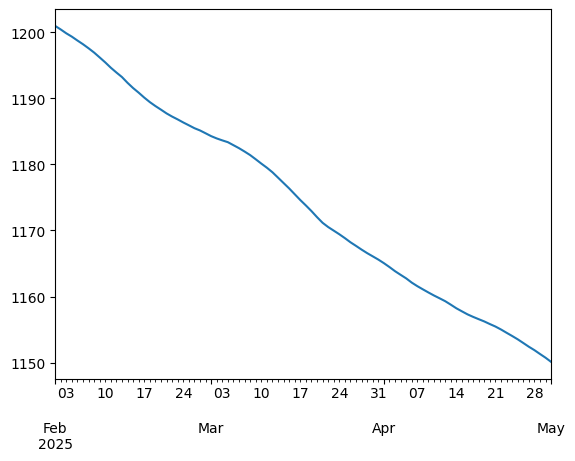

In [9]:
# df_present_value.loc[:10].transpose().plot(legend=False)
df_present_value.mean().plot(legend=False)


In [10]:
dates_project_window = np.arange(start_date, end_date + dt.timedelta(days=1))
df_project_value = pd.DataFrame([], columns=dates_project_window)
df_option_value = pd.DataFrame([], columns=dates_project_window)
df_call_value = pd.DataFrame([], columns=dates_project_window)
df_intrinsic_value = pd.DataFrame([], columns=dates_project_window)

In [11]:
def obtain_prices(prices, date):
    df_prices_aux = pd.DataFrame([])
    for price in prices:
        df_prices_aux = pd.concat([df_prices_aux, prices[price][[date]]], axis=1)
    df_prices_aux.columns = list(prices.keys())
    return df_prices_aux

In [12]:
date_nxt = dates_project_window[-1]
for date in reversed(dates_project_window):
    df_project_value[date] = df_present_value[date] - investment
    df_intrinsic_value[date] = df_project_value[date].copy()
    df_intrinsic_value.loc[df_intrinsic_value[date] < 0, date] = 0
    if date == end_date:
        df_option_value[date] = df_project_value[date].copy()
        df_option_value.loc[df_option_value[date] < 0, date] = 0
        df_call_value[date] = df_option_value[date]
        df_prices_nxt = obtain_prices(prices, date)
    else:
        df_prices = obtain_prices(prices, date)
        df_return = np.log(df_prices_nxt / df_prices)
        df_k = op.base_bs(df_prices, df_return, delta_time, rho).fillna(0)
        df_h = op.base_bs_delta(df_prices, df_return, delta_time, rho).fillna(0)
        df_m = pd.concat((df_k, df_h), axis=1)
    
        df_option_nxt = df_option_value[[date_nxt]].copy()
        df_option_nxt.rename(columns={date_nxt: 'option'}, inplace=True)
        
        mt_delta = ot.optimization(df_m, df_option_nxt)
        option_aux = np.matrix(df_k) @ mt_delta[: df_k.shape[1], :]
        
        df_call_value[date] = option_aux
        df_option_value[date] = option_aux
        df_option_value.loc[df_option_value[date] < df_intrinsic_value[date], date] = df_intrinsic_value[date]
        
        date_nxt = date
        df_prices_nxt = df_prices.copy()

<Axes: >

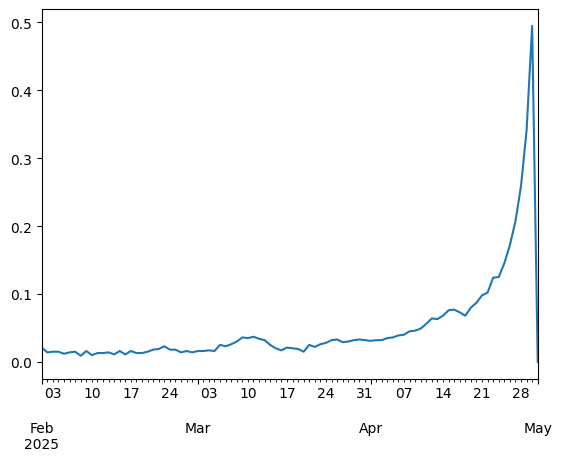

In [13]:
df_prob_aux = df_option_value.copy() * 0
df_prob_aux[df_call_value < df_intrinsic_value] = 1
(df_prob_aux.sum() / len(df_prob_aux)).plot()

<Axes: >

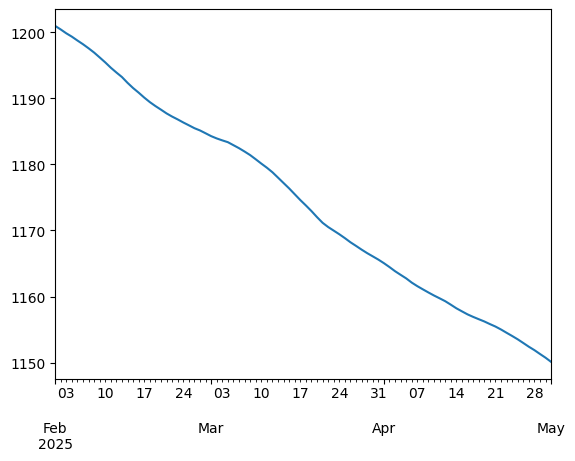

In [14]:
df_intrinsic_value.mean().plot()

<Axes: >

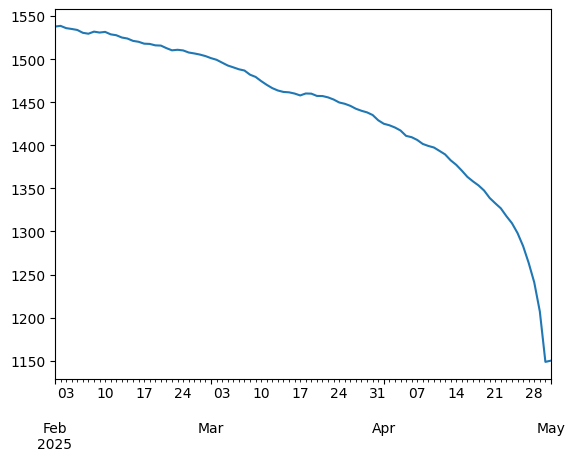

In [15]:
df_call_value.mean().plot()

<Axes: >

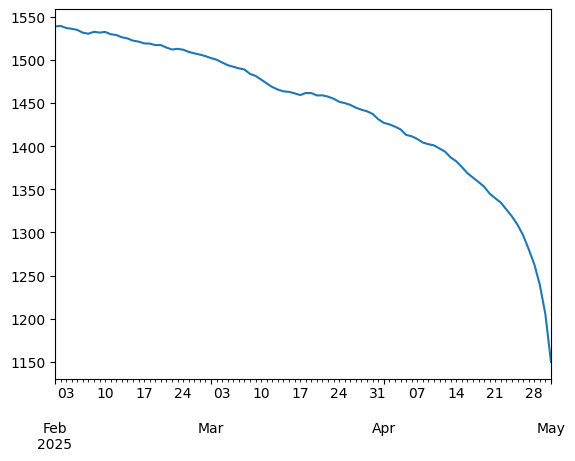

In [16]:
df_option_value.mean().plot()

<Axes: >

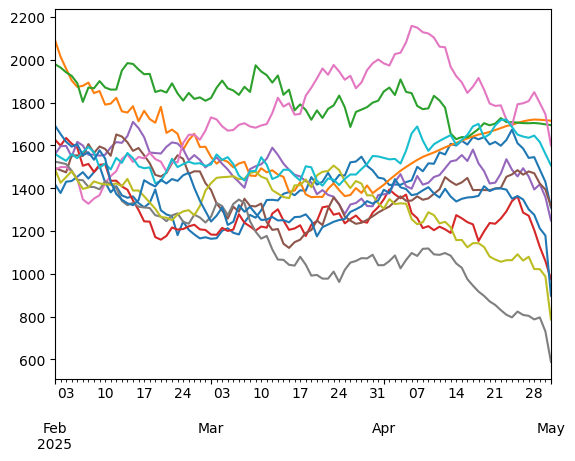

In [17]:
df_option_value.loc[:10].T.plot(legend=False)

In [18]:
df_intrinsic_value[dates_project_window[-2:]].head()

,2025-04-30,2025-05-01
0,1308.937485,1309.239428
1,1717.608441,1715.225856
2,1698.190316,1694.556434
3,980.019919,974.168665
4,1254.901784,1248.598766


In [19]:
date_aux = dates_project_window[-2]

df_results_aux = pd.concat([df_option_value[date_aux], df_intrinsic_value[date_aux]], axis=1)
df_results_aux.columns = ['option', 'intrinsic']
df_results_aux.head()

,option,intrinsic
0,1429.533024,1308.937485
1,1717.608441,1717.608441
2,1698.190316,1698.190316
3,1059.448192,980.019919
4,1358.724840,1254.901784
